In [11]:
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from pathlib import Path
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

In [2]:
data=pd.read_csv('./use_4.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1318)
feature=train_data.drop(['丙烯选择性','Unnamed: 0'],axis=1)
label=train_data['丙烯选择性']

In [3]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [4]:
def optuna_objective(trial):
    iterations=trial.suggest_int('iterations',100,1000,10)
    max_depth=trial.suggest_int("max_depth",2,15,1)
    l2_leaf_reg=trial.suggest_float("l2_leaf_reg",1,4)
    learning_rate=trial.suggest_float("learning_rate",0.05,0.3)
    reg=cb.CatBoostRegressor(iterations=iterations,
                             max_depth=max_depth,
                             l2_leaf_reg=l2_leaf_reg,
                             learning_rate=learning_rate,
                             silent=True
                             )
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
    return pow(abs(loss.mean()),0.5)

In [5]:
def optimizer_optuna(n_trials):
    algo=optuna.samplers.TPESampler(n_startup_trials=10,n_ei_candidates=24)
    study=optuna.create_study(sampler=algo,direction="minimize")
    study.optimize(optuna_objective,n_trials=n_trials,show_progress_bar=True)
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")
    
    return study.best_trial.params, study.best_trial.values

In [6]:
optimizer_optuna(10)

[I 2023-03-31 21:58:31,610] A new study created in memory with name: no-name-68c0490f-f7ad-41bd-ab38-ebaa0f5acfb7
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-31 21:58:42,690] Trial 0 finished with value: 0.789301022533415 and parameters: {'iterations': 770, 'max_depth': 9, 'l2_leaf_reg': 1.1551846946280444, 'learning_rate': 0.29583441144510564}. Best is trial 0 with value: 0.789301022533415.
[I 2023-03-31 21:58:45,543] Trial 1 finished with value: 0.8152313929762693 and parameters: {'iterations': 750, 'max_depth': 5, 'l2_leaf_reg': 1.2054157624784771, 'learning_rate': 0.25394310177608187}. Best is trial 0 with value: 0.789301022533415.
[I 2023-03-31 21:58:49,399] Trial 2 finished with value: 0.844363708255495 and parameters: {'iterations': 510, 'max_depth': 7, 'l2_leaf_reg': 1.0586019114517111, 'learning_rate': 0.1449317083288787}. Best is trial 0 with value: 0.789301022533415.
[I 2023-03-31 21:58:51,068] Trial 3 finished with value: 0.8244844164514051 and parameters: {'iterations': 430, 'max_depth': 4, 'l2_leaf_reg': 2.3552350405067384, 'learning_rate': 0.2453200083126918}. Best is trial 0 with value: 0.789301022533415.
[I 2023-

({'iterations': 770,
  'max_depth': 9,
  'l2_leaf_reg': 1.1551846946280444,
  'learning_rate': 0.29583441144510564},
 [0.789301022533415])

In [6]:
model = cb.CatBoostRegressor(iterations=190,max_depth=8,silent=True,random_state=1314,learning_rate=0.1).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.6687874833069996
rmse: 11.648442022451922


In [7]:
test_x = test_data.drop(['丙烯选择性','Unnamed: 0'],axis=1)
test_y = test_data['丙烯选择性']
test_score = model.score(test_x,test_y)
print('测试集得分为：', test_score)

测试集得分为： 0.5959086518112655


In [8]:
# 预测1
Y1=model.predict(test_data.drop(['丙烯选择性','Unnamed: 0'],axis=1))
Y2=test_data['丙烯选择性']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [9]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

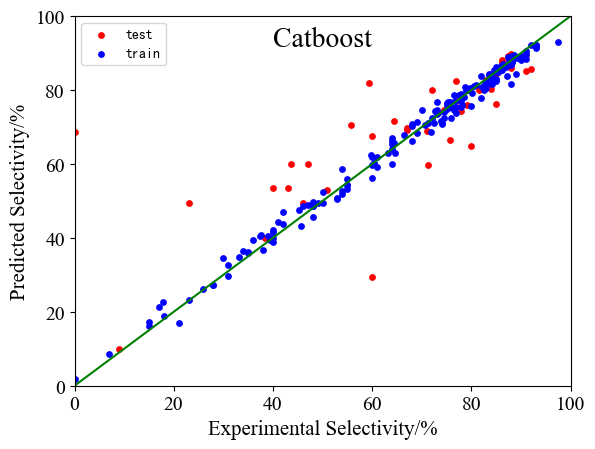

In [15]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,100))
plt.xlabel('Experimental Selectivity/%',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=14,fontname='Times New Roman')
plt.ylim((0,100))
plt.ylabel('Predicted Selectivity/%',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=14,fontname='Times New Roman')
plt.plot([0,100],[0,100],color='g')
plt.text(40,92,'Catboost',fontsize=20,font=Path('..\TimesNewRoman.ttf'))
plt.legend()
plt.show()

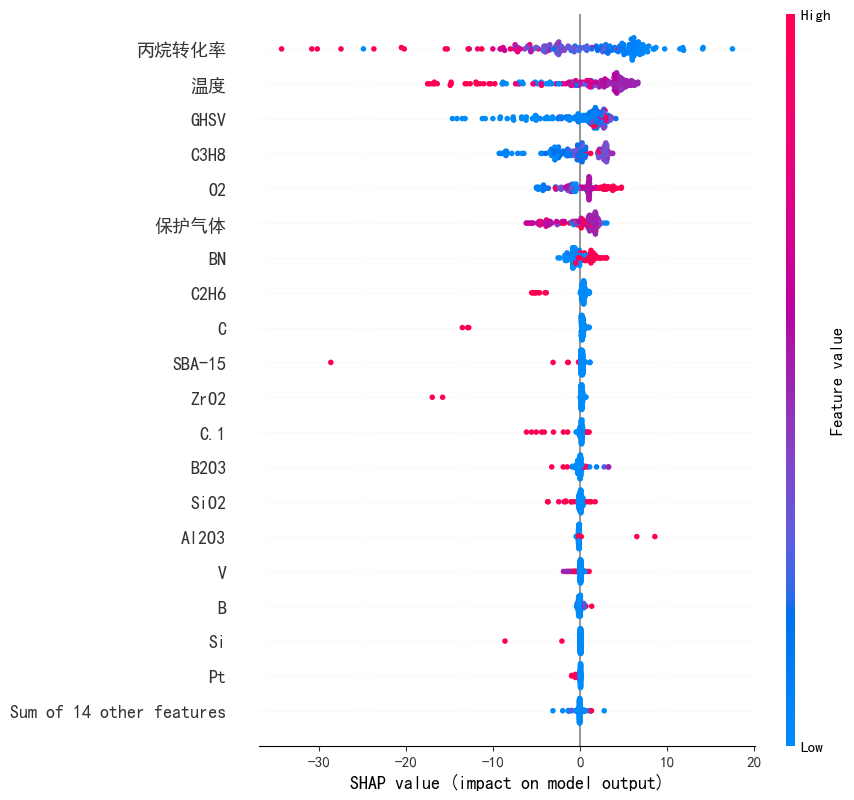

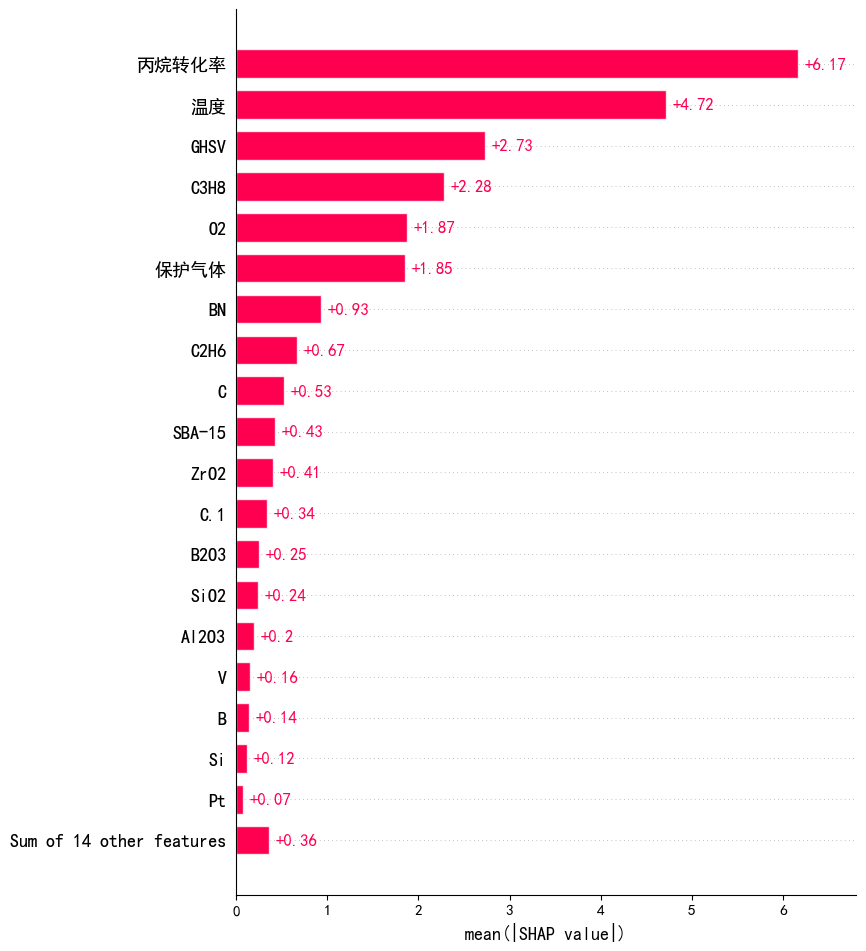

In [12]:
# shap提高解释性
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(feature)
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.bar(shap_values, max_display=20)